In [38]:
import tensorflow as tf
import tflearn
from tflearn.data_utils import to_categorical, pad_sequences
from tflearn.datasets import imdb

import pandas as pd
import numpy as np

%matplotlib inline

In [39]:
data = pd.read_csv("asset/bf_classify_v5.csv")

labels = []
for _,row in data.iterrows():
    if row['score']  > 0 :
        labels.append('Tip')
    elif row['score']  < 0:
        labels.append('notTip')
    else:
        labels.append('Unknown')


In [40]:
data['label'] = labels
data.columns

Index(['Unnamed: 0', 'CPSC.Case..', 'trmt_date', 'psu', 'weight', 'stratum',
       'age', 'sex', 'race', 'race_other', 'diag', 'diag_other', 'body_part',
       'disposition', 'location', 'fmv', 'prod1', 'prod2', 'narr1', 'narr2',
       'Narra', 'year', 'inc', 'score', 'label'],
      dtype='object')

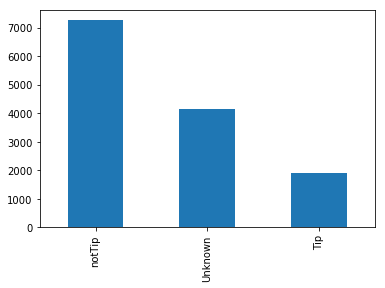

In [41]:
data.label.value_counts().plot(kind='bar')

In [42]:
data.label.value_counts()

notTip     7255
Unknown    4148
Tip        1923
Name: label, dtype: int64

In [43]:
from string import punctuation
import re

incidents = []

regex = re.compile('[%s]' % re.escape(punctuation))

for index, row in data.iterrows():
    out = regex.sub(' ', row['Narra'])
    incidents.append(out)


In [44]:
np.array(incidents[0:5])

array([ '8YOM PULLED A 36IN TV DOWN ONTO SELF OFF DRESSER   STRUCK ON SHOULDER JAW',
       '52 Y O M   DRESSER FELL ON FOOT   DX CONTUSION OF FOOT',
       '13 YR F STUBBED TOE ON DRESSER DX CONTUSED TOE',
       '4 YO FEMALE HIT NECK ON DRESSER   DX CONTUSION',
       '31YOF WAS HELPING SOMEONE MOVE AND CAUGHT LEFT HAND BETWEEN A TRUCKAND A CHEST'], 
      dtype='<U78')

In [45]:
from collections import Counter

total_counts = Counter()

for row in incidents:
        total_counts.update(row.split(" "))

print("Total words in data set: ", len(total_counts))

Total words in data set:  6162


In [46]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:10000]
print(vocab[:60])

['', 'DRESSER', 'ON', 'FELL', 'A', 'AND', 'HEAD', 'DX', 'HIT', 'OF', 'TO', 'HOME', 'AT', 'CHEST', 'BED', 'LAC', 'THE', 'PAIN', 'CONTUSION', 'LACERATION', 'YOF', 'WAS', 'HITTING', 'YOM', 'PT', 'YO', 'BACK', 'FACE', 'WHEN', 'MOVING', 'FOOT', 'OFF', 'INJURY', 'O', 'INTO', 'HER', 'TOE', 'HAND', 'IN', 'SCALP', 'AGAINST', 'F', 'OUT', 'STRUCK', 'WITH', 'M', 'ONTO', 'FX', 'FOREHEAD', 'DRAWER', 'WHILE', 'AFTER', 'MALE', 'YR', 'FROM', 'FEMALE', '2', 'TRIPPED', 'CORNER', 'OLD']


In [47]:
word2idx = {word: i for i, word in enumerate(vocab)}
list(word2idx.items())[0:20]

[('', 0),
 ('CONRER', 2063),
 ('ALVUSION', 2828),
 ('BATHROOMLANDED', 2829),
 ('RTLEG', 2830),
 ('STRKE', 3497),
 ('53YOF', 458),
 ('TOPROSIMALL', 2832),
 ('87Y', 2833),
 ('LUMBER', 2865),
 ('8MF', 2835),
 ('HIPFRACTURE', 2836),
 ('PAINTED', 2837),
 ('SUBSTERNAL', 2838),
 ('SLIPPEDOFF', 2068),
 ('ANKLE', 126),
 ('GINGIVA', 2839),
 ('TODAY7', 2840),
 ('FATHER', 872),
 ('HANDDX', 766)]

In [48]:
def text_to_index(text):
    word_vector= []
    
    for word in text.split(' '):
        idx = word2idx.get(word, 6174 )
        word_vector.append(idx)
    return word_vector

In [49]:
text_to_index("28 YOM FELT SNAP IN WRIST WHILE LIFTING ARMOIREWRIST SPRAIN")

[319, 23, 197, 1750, 38, 99, 50, 100, 4412, 106]

In [50]:
text_to_index("3YOF CLIMBING ON DRESSER ARMOIRE")

[171, 86, 2, 1, 300]

In [51]:
incidentsIdx = []

for row in incidents:
        incidentsIdx.append(text_to_index(row))

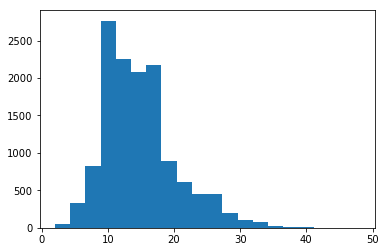

In [52]:
len_indx = []
for row in incidentsIdx:
    len_indx.append(len(row))

from matplotlib import pyplot as plt
plt.hist(len_indx, bins=20,)
plt.show()

In [53]:
unknownIdx = []
train = []
target = []
for x, y in zip(incidentsIdx, labels):
    if(y == 'Unknown'):
        unknownIdx.append(x)
    else:
        train.append(x)
        target.append(y)    

In [54]:
Y = list([1 if each == 'Tip' else 0 for each in target])

In [55]:
len(Y)

9178

In [56]:
len(train)

9178

In [57]:
from sklearn.model_selection import train_test_split

trainX,testX,trainY,testY = train_test_split(train, Y, test_size=0.2, random_state=42)

In [58]:
# Data preprocessing
# Sequence padding
trainX = pad_sequences(trainX, maxlen=40, value=0. , padding='pre')
testX = pad_sequences(testX, maxlen=40, value=0., padding='pre')
# Converting labels to binary vectors
trainY = to_categorical(trainY, nb_classes=2)
testY = to_categorical(testY, nb_classes=2)

# RNN
# Network building
>net = tflearn.input_data([None, 30])

>net = tflearn.embedding(net, input_dim=10000, output_dim=128)

>net = tflearn.lstm(net, 64, dropout=0.8)

>net = tflearn.fully_connected(net, 2, activation='softmax')

>net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

In [59]:
# Network building
from tflearn.layers.recurrent import bidirectional_rnn, BasicLSTMCell
from tflearn.layers.core import input_data, dropout, fully_connected

tf.reset_default_graph()

net = tflearn.input_data([None, 40])
net = tflearn.embedding(net, input_dim=10000, output_dim=128)
net = bidirectional_rnn(net, BasicLSTMCell(128), BasicLSTMCell(128))
net = dropout(net, 0.5)
#net = tflearn.lstm(net, 64, dropout=0.8)
net = tflearn.fully_connected(net, 2, activation='softmax')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy')

In [60]:
# Training
model = tflearn.DNN(net, tensorboard_verbose=2)
model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
          batch_size=32, n_epoch=10)

Training Step: 2299  | total loss: 0.02837 | time: 48.674s
| Adam | epoch: 010 | loss: 0.02837 - acc: 0.9953 -- iter: 7328/7342
Training Step: 2300  | total loss: 0.02576 | time: 50.296s
| Adam | epoch: 010 | loss: 0.02576 - acc: 0.9958 | val_loss: 0.19522 - val_acc: 0.9428 -- iter: 7342/7342
--


In [64]:
predictions = (np.array(model.predict(testX))[:,0] >= 0.5).astype(np.int_)
test_accuracy = np.mean(predictions == testY[:,0], axis=0)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.942810457516


In [65]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(predictions, testY[:,0], labels = [0,1])
cm

array([[ 318,   73],
       [  32, 1413]])

In [66]:
tp = float(cm[0][0])/np.sum(cm[0])
tn = float(cm[1][1])/np.sum(cm[1])

print(tp)
print(tn)



0.813299232737
0.97785467128


# Try My Own Sentense!

In [79]:
# Helper function that uses your model to predict sentiment
def predict_sentence(sentence):
    positive_prob = model.predict(pad_sequences([text_to_index(sentence)], maxlen=40, value=0.))[0][1]
    print('Sentence: {}'.format(sentence))
    print('P(positive) = {:.3f} :'.format(positive_prob), 
          'Tip' if positive_prob > 0.5 else 'Not tip')

In [80]:
sentence = "2 YO FEMALE SHUT FINGER IN A BUREAU  DX FINGER LACERATION"
predict_sentence(sentence)

Sentence: 2 YO FEMALE SHUT FINGER IN A BUREAU  DX FINGER LACERATION
P(positive) = 0.044 : Not tip


In [81]:
sentence = "39 Y O M LACERATED FACE WHEN HE STRUCK A BUREAU WHILE SLEEP WALKING"
predict_sentence(sentence)

Sentence: 39 Y O M LACERATED FACE WHEN HE STRUCK A BUREAU WHILE SLEEP WALKING
P(positive) = 0.047 : Not tip


In [82]:
sentence = "2 YOM DECEDENT HAD A 27 INCH TELEVISION FALL ON HIM FROM THE TOP OF A CHEST OF DRAWERS. "
predict_sentence(sentence)

Sentence: 2 YOM DECEDENT HAD A 27 INCH TELEVISION FALL ON HIM FROM THE TOP OF A CHEST OF DRAWERS. 
P(positive) = 0.873 : Tip


In [86]:
sentence = "PT PLAYING ON DRESSOR AND IT FELL ON HIM"
predict_sentence(sentence)

Sentence: PT PLAYING ON DRESSOR AND IT FELL ON HIM
P(positive) = 0.038 : Not tip


In [97]:
sentence = "2 YOM CLIMBING ON DRESSOR AND IT TIPPED OVER"
predict_sentence(sentence)

Sentence: 2 YOM CLIMBING ON DRESSOR AND IT TIPPED OVER
P(positive) = 0.960 : Tip


In [95]:
sentence = "HE FELL ON DRESSOR"
predict_sentence(sentence)

Sentence: HE FELL ON DRESSOR
P(positive) = 0.039 : Not tip


In [94]:
sentence = "DESSOR FELL ON HIM"
predict_sentence(sentence)

Sentence: DESSOR FELL ON HIM
P(positive) = 0.813 : Tip


In [104]:
sentence = "FEMALE TRIPPED A BUREAU AND TELEVISION FALL ON HER"
predict_sentence(sentence)

Sentence: FEMALE TRIPPED A BUREAU AND TELEVISION FALL ON HER
P(positive) = 0.043 : Not tip


# Apply to Unknown

In [76]:
positive_prob = []
predicted_label = []
for i in unknownIdx:
    prob = model.predict(pad_sequences([i], maxlen=40, value=0.))[0][1]
    positive_prob.append(prob) 
    predicted_label.append('Tip over' if prob > 0.5 else 'Not tip over')

In [77]:
df_result = pd.DataFrame({
                'tipover prob': positive_prob,
                'predicted label': predicted_label,
                'unknownIdx': unknownIdx
             })

In [78]:
df_result.to_csv("result.csv")